In [3]:
!conda install tqdm -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs: 
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.5.4                |           py36_0         1.0 MB
    tqdm-4.23.0                |           py36_0          56 KB
    ------------------------------------------------------------
                                           Total:         1.1 MB

The following NEW packages will be INSTALLED:

    tqdm:  4.23.0-py36_0

The following packages will be UPDATED:

    conda: 4.5.2-py36_0  --> 4.5.4-py36_0


conda 4.5.4############################################################# | 100% 
tqdm 4.23.0############################################################# | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [1]:
import tqdm
import numpy as np

In [2]:
from pfm_utils import readPFM

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import torch
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--lr', '--learning-rate', default=2e-4, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum for sgd, alpha parameter for adam')
parser.add_argument('--beta', default=0.999, type=float, metavar='M',
                    help='beta parameters for adam')
parser.add_argument('--weight-decay', '--wd', default=0, type=float,
                    metavar='W', help='weight decay')
parser.add_argument('--epochs', default=60, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch-size', default=6, type=int,
                    metavar='N', help='mini-batch size')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers')

args = parser.parse_args(["--lr", "0.01", "-b", "6"])

In [5]:
#FIXME add loading from weights
# weights = torch.load('dispnet_model_best.pth.tar')
# disp_net.load_state_dict(weights['state_dict'])

In [5]:
import torchvision

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, left_img, right_img, disp_map):
        for t in self.transforms:
            left_img, right_img, disp_map = t(left_img, right_img, disp_map)
        return left_img, right_img, disp_map


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, left_img, right_img, disp_map):
        for tensor in [left_img, right_img]:
            for t, m, s in zip(tensor, self.mean, self.std):
                t.sub_(m).div_(s)
        return left_img, right_img, disp_map
    

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, left_img, right_img, disp_map):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W

        left_img = torch.from_numpy(left_img.transpose((2, 0, 1)))
        right_img = torch.from_numpy(right_img.transpose((2, 0, 1)))
        disp_map = torch.from_numpy(disp_map.copy())
       
        return left_img, right_img, disp_map
    


train_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [7]:
import numpy as np

train_fnames = np.load('train_fnames.npy')
test_fnames = np.load('test_fnames.npy')
val_fnames = np.load('val_fnames.npy')

In [8]:
from data_loader import SequenceFolder

#3600 objects
train_set = SequenceFolder(train_fnames, transform=train_transform)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True) #pin_memory=False

#100 objects
val_set = SequenceFolder(val_fnames, transform=train_transform)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1, shuffle=True,
    num_workers=args.workers, pin_memory=True)

Text(0.5,1,'Right')

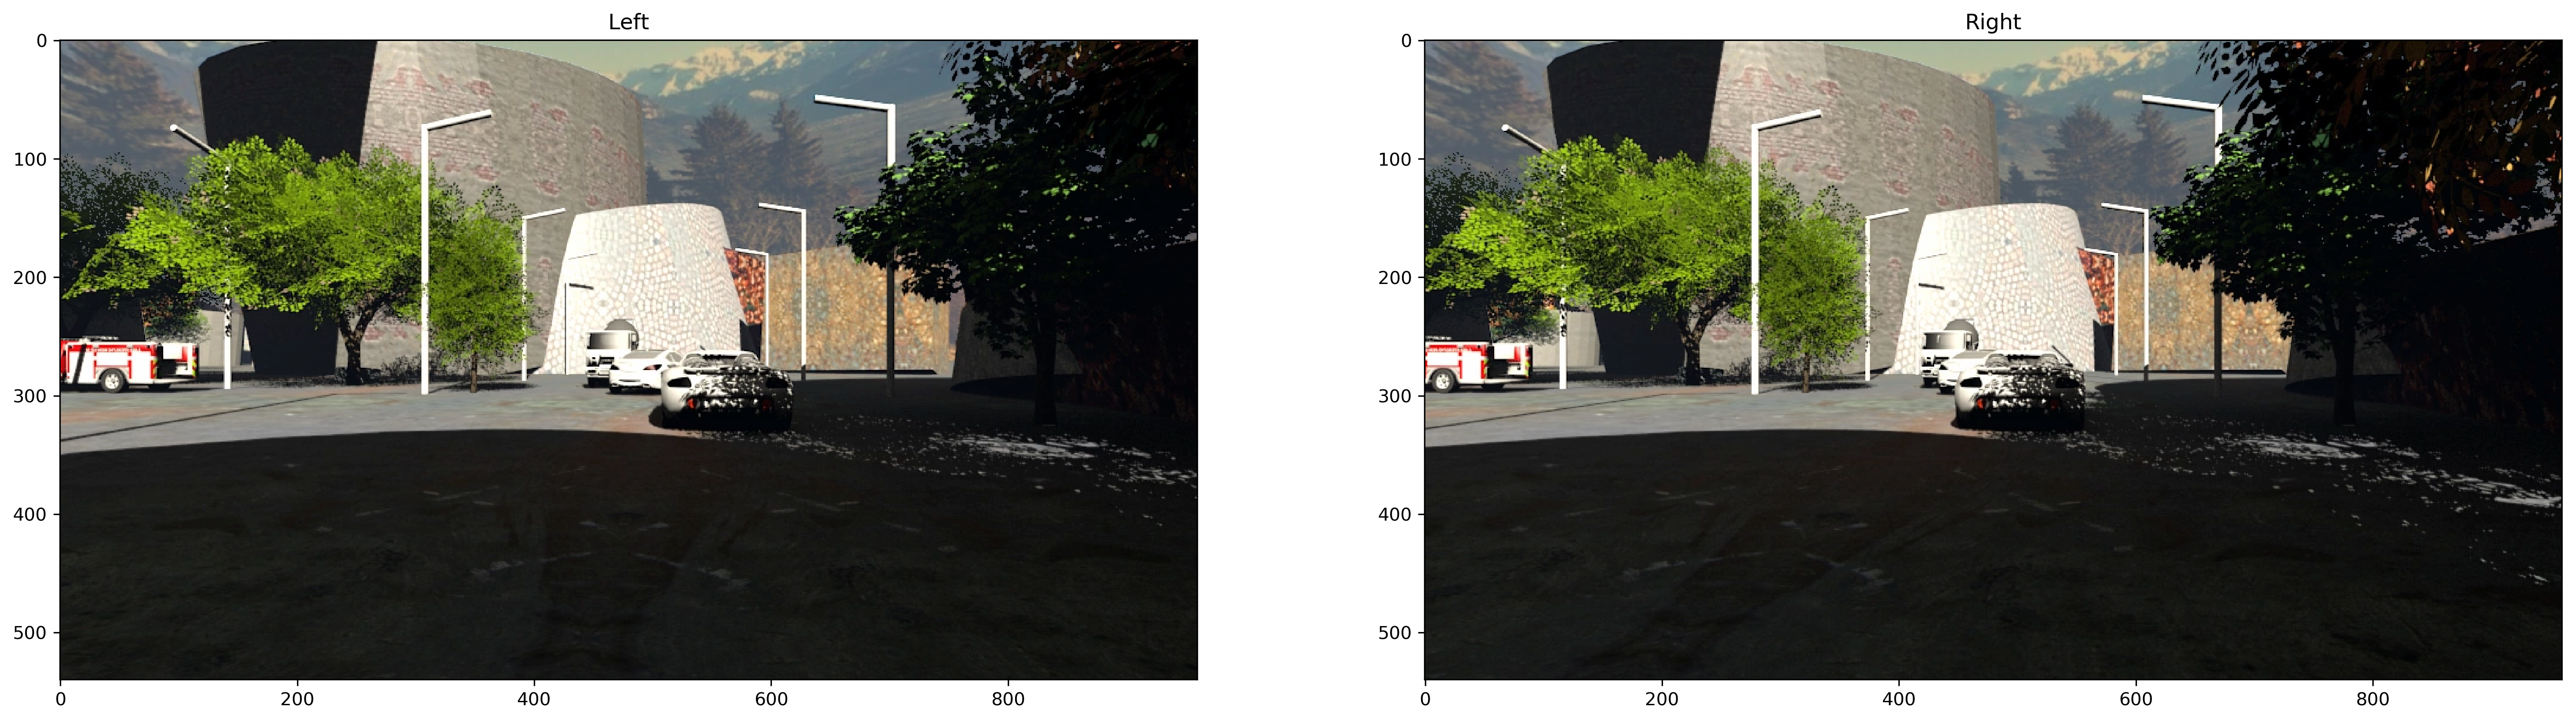

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

ind = 0
left_img, right_img, disp_map = train_set[ind]
left_img = left_img.numpy().transpose((1,2,0))
right_img = right_img.numpy().transpose((1,2,0))


plt.figure(num=None, figsize=(25,10),dpi=300)
plt.subplot(121)
plt.imshow((left_img+1)/2)
plt.title("Left")

plt.subplot(122)
plt.imshow((right_img+1)/2)
plt.title("Right")

In [9]:
import numpy as np
import torch
from os.path import join
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import time

%matplotlib inline

In [3]:
from DispNet_QR import DispNet
disp_net = DispNet()
disp_net.init_weights()
disp_net.cuda()

DispNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv3a): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv3b): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (conv4a): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512,

In [10]:
def get_segment(value, step = 30, n_segments = 10):
    segment_num = value.long()/step
    segment_num = segment_num.where(segment_num<n_segments, torch.LongTensor([n_segments-1]))
    offset = value - (segment_num*step).float()
    return segment_num, offset

In [4]:
# disp_net = torch.load('disp_net-last-qr.pth')
# disp_net.cuda()

In [12]:
N_train = len(train_set)
N_val = len(val_set)

In [13]:
parameters = disp_net.parameters()
optimizer = torch.optim.Adam(parameters, args.lr,
                             betas=(args.momentum, args.beta),
                             weight_decay=args.weight_decay)

In [18]:
def shift_weights(weights):
    return weights[1:]+[weights[0]]

In [14]:
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import tqdm
import time

loss_func = nn.MSELoss()
logloss_func = nn.CrossEntropyLoss()
train_loss = []
val_loss = []

weights = [0.9, 0.1, 0, 0, 0, 0]
# for n_epochs in [20, 30, 30, 50]:
#     print("curr_n_epochs:", n_epochs)
#     weights = shift_weights(weights)
w1, w2, w3, w4, w5, w6 = weights
for epoch in range(60):#range(args.epochs):
    disp_net.train()
    start_time = time.time()
    for left_img, right_img, disp_map in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        X_batch = Variable(torch.cat((left_img, right_img), 1).float())
        disp_map0, disp_map1, disp_map2, disp_map3, disp_map4, disp_map5, disp_map6 = disp_map
        y_batch1 = Variable(disp_map1)
        y_batch2 = Variable(disp_map2)
        y_batch3 = Variable(disp_map3)
        y_batch4 = Variable(disp_map4)
        y_batch5 = Variable(disp_map5)
        y_batch6 = Variable(disp_map6)

        segments, offsets = get_segment(y_batch1.unsqueeze_(1))
        segments_pred, offsets_pred, disp2, disp3, disp4, disp5, disp6 = disp_net(X_batch.cuda()) #concatenate on channel
        #segments_pred, offsets_pred = disp1
#         print("segments_pred", segments_pred.size())
#         print("offsets_pred", offsets_pred.size())
#         print("segments", segments.size())
#         print("offsets", offsets.size())        
        
        pred = segments_pred.argmax(1, keepdim=True).float()*30+offsets_pred.gather(1, segments.cuda())
        loss_1 = logloss_func(segments_pred.permute(0, 2, 3, 1).contiguous().view(-1, 10), segments.permute(0, 2, 3, 1).contiguous().view(-1, 1).squeeze(1).cuda()) 
#         print(offsets_pred)
#         print("segments",segments)
        loss_2 = loss_func(offsets_pred.gather(1, segments.cuda()), offsets.cuda())
        loss = 100000*loss_1 + 0.1*loss_2
#         loss = w1*loss_func(disp1.squeeze(1), y_batch1.cuda()) + w2*loss_func(disp2.squeeze(1), y_batch2.cuda()) \
#                 + w3*loss_func(disp3.squeeze(1), y_batch3.cuda()) + w4*loss_func(disp4.squeeze(1), y_batch4.cuda()) \
#                 + w5*loss_func(disp5.squeeze(1), y_batch5.cuda()) + w6*loss_func(disp6.squeeze(1), y_batch6.cuda())
        train_loss.append(np.asscalar(loss.data.cpu().numpy()))
        loss.backward()
        optimizer.step()
    print(loss_func(pred, y_batch1.cuda()))
    torch.cuda.empty_cache()
    torch.save(disp_net,"disp_net-last-qr.pth")
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, args.epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-N_train // args.batch_size :])))
    with open('log', 'a') as f:
        f.write("Epoch {} of {} took {:.3f}s\n".format(
        epoch + 1, args.epochs, time.time() - start_time))
        f.write("  training loss (in-iteration): \t{:.6f}\n\n".format(
        np.mean(train_loss[-N_train // args.batch_size :])))

    # And a full pass over the validation data:
    # disable dropout / use averages for batch_norm    
    disp_net.eval()
    for left_img, right_img, disp_map in val_loader:
        X_batch = Variable(torch.cat((left_img, right_img), 1).float())
        disp_map0, _, _, _, _, _, _ = disp_map
        y_batch = Variable(disp_map0)
        disp0 = disp_net(X_batch.cuda()) #concatenate on channel
        pred = disp0.squeeze(1)
        loss = loss_func(pred, y_batch.cuda())
        val_loss.append(np.asscalar(loss.data.cpu().numpy()))
    torch.cuda.empty_cache()
    print("  validation loss: \t\t\t{:.6f}".format(
        np.mean(val_loss[-N_val // 1 :])))

100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(590.8041, device='cuda:0')
Epoch 1 of 60 took 473.178s
  training loss (in-iteration): 	79813.352891


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			598.743372


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(216.8515, device='cuda:0')
Epoch 2 of 60 took 473.217s
  training loss (in-iteration): 	48354.694876


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			411.055382


100%|██████████| 600/600 [07:50<00:00,  1.28it/s]


tensor(284.8969, device='cuda:0')
Epoch 3 of 60 took 472.314s
  training loss (in-iteration): 	39354.301273


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			295.820064


100%|██████████| 600/600 [07:50<00:00,  1.28it/s]


tensor(252.0510, device='cuda:0')
Epoch 4 of 60 took 472.082s
  training loss (in-iteration): 	34675.792666


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			347.550460


100%|██████████| 600/600 [07:50<00:00,  1.27it/s]


tensor(256.6166, device='cuda:0')
Epoch 5 of 60 took 472.922s
  training loss (in-iteration): 	30673.422142


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			279.797968


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(235.7271, device='cuda:0')
Epoch 6 of 60 took 473.376s
  training loss (in-iteration): 	27858.690856


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			255.762483


100%|██████████| 600/600 [07:50<00:00,  1.27it/s]


tensor(186.6020, device='cuda:0')
Epoch 7 of 60 took 472.578s
  training loss (in-iteration): 	26273.148734


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			155.001450


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(161.2887, device='cuda:0')
Epoch 8 of 60 took 472.996s
  training loss (in-iteration): 	24347.558911


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			168.672821


100%|██████████| 600/600 [07:50<00:00,  1.27it/s]


tensor(143.9358, device='cuda:0')
Epoch 9 of 60 took 472.745s
  training loss (in-iteration): 	23263.513110


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			151.308753


100%|██████████| 600/600 [07:50<00:00,  1.28it/s]


tensor(242.6081, device='cuda:0')
Epoch 10 of 60 took 472.307s
  training loss (in-iteration): 	21771.586211


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			143.764167


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(135.0352, device='cuda:0')
Epoch 11 of 60 took 473.568s
  training loss (in-iteration): 	21188.149424


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			148.084134


100%|██████████| 600/600 [07:52<00:00,  1.27it/s]


tensor(238.2860, device='cuda:0')
Epoch 12 of 60 took 474.055s
  training loss (in-iteration): 	20061.244234


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			149.745242


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(228.6120, device='cuda:0')
Epoch 13 of 60 took 473.364s
  training loss (in-iteration): 	19891.528887


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			151.047014


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(124.6776, device='cuda:0')
Epoch 14 of 60 took 473.530s
  training loss (in-iteration): 	18760.537759


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			136.113770


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(201.4294, device='cuda:0')
Epoch 15 of 60 took 474.068s
  training loss (in-iteration): 	18447.492412


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			152.877668


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(120.5349, device='cuda:0')
Epoch 16 of 60 took 473.455s
  training loss (in-iteration): 	17928.457878


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			127.562783


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(123.7446, device='cuda:0')
Epoch 17 of 60 took 473.948s
  training loss (in-iteration): 	17342.778843


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			134.380057


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(139.9559, device='cuda:0')
Epoch 18 of 60 took 472.283s
  training loss (in-iteration): 	16672.537173


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			126.812491


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(280.4439, device='cuda:0')
Epoch 19 of 60 took 473.773s
  training loss (in-iteration): 	16636.725962


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			127.317051


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(168.4433, device='cuda:0')
Epoch 20 of 60 took 473.624s
  training loss (in-iteration): 	16161.175033


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			121.974907


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(128.7911, device='cuda:0')
Epoch 21 of 60 took 473.801s
  training loss (in-iteration): 	15858.930393


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			206.589259


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(189.2735, device='cuda:0')
Epoch 22 of 60 took 473.520s
  training loss (in-iteration): 	16357.698733


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			116.855737


100%|██████████| 600/600 [07:52<00:00,  1.27it/s]


tensor(95.5268, device='cuda:0')
Epoch 23 of 60 took 473.947s
  training loss (in-iteration): 	14926.534792


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			122.794401


100%|██████████| 600/600 [07:52<00:00,  1.27it/s]


tensor(153.2316, device='cuda:0')
Epoch 24 of 60 took 474.161s
  training loss (in-iteration): 	14978.098804


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			115.572273


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(144.2053, device='cuda:0')
Epoch 25 of 60 took 472.767s
  training loss (in-iteration): 	14557.435615


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			116.674715


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(104.9935, device='cuda:0')
Epoch 26 of 60 took 473.179s
  training loss (in-iteration): 	14141.456125


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			135.605594


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(150.2721, device='cuda:0')
Epoch 27 of 60 took 473.766s
  training loss (in-iteration): 	14118.104009


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			121.099115


100%|██████████| 600/600 [07:52<00:00,  1.27it/s]


tensor(181.6170, device='cuda:0')
Epoch 28 of 60 took 473.933s
  training loss (in-iteration): 	13953.698420


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			113.144667


100%|██████████| 600/600 [07:51<00:00,  1.27it/s]


tensor(170.0624, device='cuda:0')
Epoch 29 of 60 took 473.644s
  training loss (in-iteration): 	13732.460497


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			120.515800


100%|██████████| 600/600 [07:50<00:00,  1.27it/s]


tensor(130.2161, device='cuda:0')
Epoch 30 of 60 took 473.031s
  training loss (in-iteration): 	13215.506954


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			115.002862


100%|██████████| 600/600 [07:52<00:00,  1.27it/s]


tensor(146.5198, device='cuda:0')
Epoch 31 of 60 took 474.326s
  training loss (in-iteration): 	13632.495463


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			107.991940


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(100.3736, device='cuda:0')
Epoch 32 of 60 took 474.501s
  training loss (in-iteration): 	13027.237188


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			101.698167


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(127.1698, device='cuda:0')
Epoch 33 of 60 took 475.184s
  training loss (in-iteration): 	12911.809124


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			93.864710


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(171.6795, device='cuda:0')
Epoch 34 of 60 took 474.682s
  training loss (in-iteration): 	12623.464632


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			101.399009


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(130.6170, device='cuda:0')
Epoch 35 of 60 took 474.860s
  training loss (in-iteration): 	12592.990090


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			94.663260


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(105.6714, device='cuda:0')
Epoch 36 of 60 took 475.346s
  training loss (in-iteration): 	12583.512628


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			105.931787


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(87.1858, device='cuda:0')
Epoch 37 of 60 took 475.407s
  training loss (in-iteration): 	12353.878135


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			98.419960


100%|██████████| 600/600 [07:54<00:00,  1.26it/s]


tensor(62.8726, device='cuda:0')
Epoch 38 of 60 took 476.802s
  training loss (in-iteration): 	12597.043103


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			89.717497


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(106.7621, device='cuda:0')
Epoch 39 of 60 took 475.837s
  training loss (in-iteration): 	12128.206401


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			89.565106


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(97.8130, device='cuda:0')
Epoch 40 of 60 took 475.134s
  training loss (in-iteration): 	11705.992700


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			96.560947


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(109.0289, device='cuda:0')
Epoch 41 of 60 took 474.924s
  training loss (in-iteration): 	11760.214967


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			93.120238


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(94.0193, device='cuda:0')
Epoch 42 of 60 took 474.729s
  training loss (in-iteration): 	12236.611244


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			90.659619


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(137.9656, device='cuda:0')
Epoch 43 of 60 took 475.324s
  training loss (in-iteration): 	11510.680055


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			89.344831


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(101.4315, device='cuda:0')
Epoch 44 of 60 took 475.578s
  training loss (in-iteration): 	11227.113619


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			87.258447


100%|██████████| 600/600 [07:52<00:00,  1.27it/s]


tensor(71.6948, device='cuda:0')
Epoch 45 of 60 took 474.259s
  training loss (in-iteration): 	11450.907102


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			99.534278


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(80.2585, device='cuda:0')
Epoch 46 of 60 took 476.189s
  training loss (in-iteration): 	11102.265222


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			90.670791


100%|██████████| 600/600 [07:54<00:00,  1.26it/s]


tensor(104.1850, device='cuda:0')
Epoch 47 of 60 took 476.744s
  training loss (in-iteration): 	11255.981528


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			90.359055


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(79.4312, device='cuda:0')
Epoch 48 of 60 took 476.506s
  training loss (in-iteration): 	10997.125870


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			86.832858


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(85.4102, device='cuda:0')
Epoch 49 of 60 took 475.757s
  training loss (in-iteration): 	11445.890256


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			89.734775


100%|██████████| 600/600 [07:52<00:00,  1.27it/s]


tensor(79.7143, device='cuda:0')
Epoch 50 of 60 took 474.794s
  training loss (in-iteration): 	10838.491276


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			89.672844


100%|██████████| 600/600 [07:54<00:00,  1.26it/s]


tensor(101.7537, device='cuda:0')
Epoch 51 of 60 took 477.069s
  training loss (in-iteration): 	10601.905785


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			87.872878


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(114.1265, device='cuda:0')
Epoch 52 of 60 took 475.608s
  training loss (in-iteration): 	10659.707964


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			94.125796


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(75.2077, device='cuda:0')
Epoch 53 of 60 took 475.165s
  training loss (in-iteration): 	10614.068507


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			88.415073


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(106.4438, device='cuda:0')
Epoch 54 of 60 took 474.832s
  training loss (in-iteration): 	10750.131868


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			86.443912


100%|██████████| 600/600 [07:52<00:00,  1.27it/s]


tensor(86.9758, device='cuda:0')
Epoch 55 of 60 took 474.385s
  training loss (in-iteration): 	10439.070982


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			84.153859


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(62.1756, device='cuda:0')
Epoch 56 of 60 took 475.017s
  training loss (in-iteration): 	10401.572707


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			84.123970


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(71.4818, device='cuda:0')
Epoch 57 of 60 took 475.648s
  training loss (in-iteration): 	10637.130581


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			93.941581


100%|██████████| 600/600 [07:53<00:00,  1.27it/s]


tensor(88.3915, device='cuda:0')
Epoch 58 of 60 took 475.342s
  training loss (in-iteration): 	10405.722908


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			83.789977


100%|██████████| 600/600 [07:52<00:00,  1.27it/s]


tensor(84.1008, device='cuda:0')
Epoch 59 of 60 took 474.472s
  training loss (in-iteration): 	10191.980225


  0%|          | 0/600 [00:00<?, ?it/s]

  validation loss: 			94.360921


100%|██████████| 600/600 [07:52<00:00,  1.27it/s]


tensor(88.6365, device='cuda:0')
Epoch 60 of 60 took 474.753s
  training loss (in-iteration): 	10123.326708
  validation loss: 			94.783190


In [20]:
torch.save(disp_net,"disp_net-last-qr.pth")

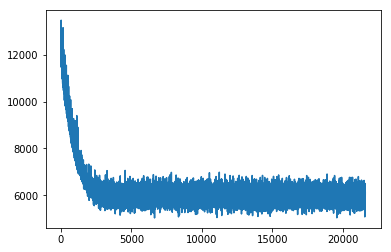

In [20]:
plt.plot(np.asarray(train_loss))

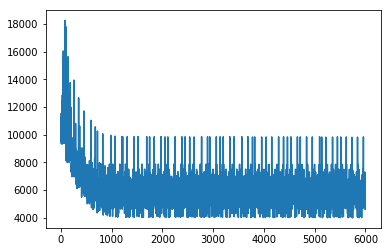

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.asarray(val_loss))

In [22]:
np.save('train_loss-last',train_loss)
np.save('val_loss-last',val_loss)

In [16]:

#700 objects
test_set = SequenceFolder(test_fnames, transform=train_transform)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=1, shuffle=False,
    num_workers=args.workers, pin_memory=True)
N_test = len(test_set)

In [19]:
%%time
disp_net.eval()

test_loss = []
for left_img, right_img, disp_map in test_loader:
    X_batch = Variable(torch.cat((left_img, right_img), 1).float())
    disp_map0, _, _, _, _, _, _ = disp_map
    y_batch = Variable(disp_map0)
    disp0 = disp_net(X_batch.cuda()) #concatenate on channel
    pred = disp0.squeeze(1)
    loss = loss_func(pred, y_batch.cuda())
    test_loss.append(np.asscalar(loss.data.cpu().numpy()))

print("  test loss: \t\t\t{:.6f}".format(
    np.mean(test_loss[-N_test // args.batch_size :])))

  test loss: 			89.901345
CPU times: user 2min 14s, sys: 35.8 s, total: 2min 50s
Wall time: 44.9 s


In [23]:
ind = 183
disp_net.eval()
left_img, right_img, disp_map = test_set[ind]
disp_map0, disp_map1, disp_map2, disp_map3, disp_map4, disp_map5, disp_map6 = disp_map
X = torch.Tensor(np.concatenate((left_img, right_img), 0)).unsqueeze(0)
disp0 = disp_net(X.cuda())

In [20]:
ind = 183
disp_net.train()
left_img, right_img, disp_map = test_set[ind]
disp_map0, disp_map1, disp_map2, disp_map3, disp_map4, disp_map5, disp_map6 = disp_map
X = torch.Tensor(np.concatenate((left_img, right_img), 0)).unsqueeze(0)
disp0 = disp_net(X.cuda())

In [53]:
np.unique(disp1_probs.argmax(1).data.cpu().numpy())

array([0, 1])

In [20]:
ind = 0
left_img, right_img, disp_map = test_set[ind]
disp_map1, disp_map2, disp_map3, disp_map4, disp_map5, disp_map6 = disp_map
X = torch.Tensor(np.concatenate((left_img, right_img), 0)).unsqueeze(0)
disp1, disp2, disp3, disp4, disp5, disp6  = disp_net(X.cuda())

Text(0.5,1,'Right')

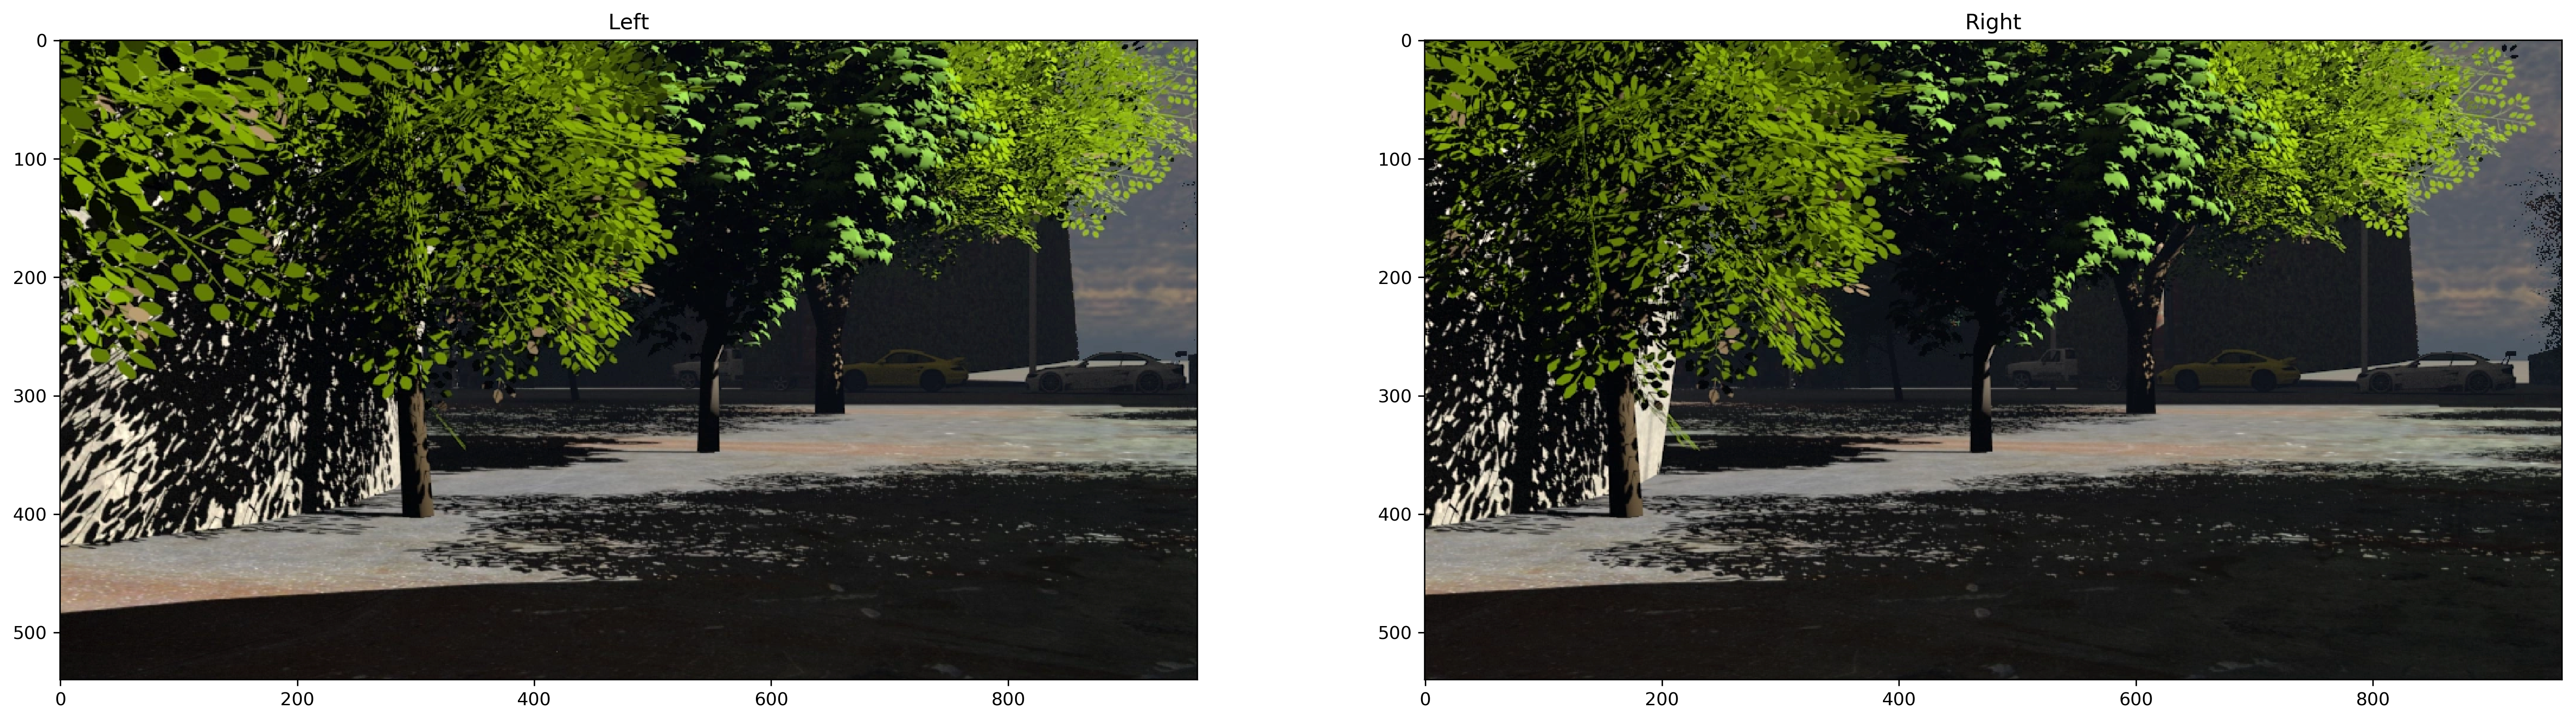

In [24]:
left_img = left_img.numpy().transpose((1,2,0))
right_img = right_img.numpy().transpose((1,2,0))


plt.figure(num=None, figsize=(25,10),dpi=300)
plt.subplot(121)
plt.imshow((left_img+1)/2)
plt.title("Left")

plt.subplot(122)
plt.imshow((right_img+1)/2)
plt.title("Right")

Text(0.5,1,'Pred - disp')

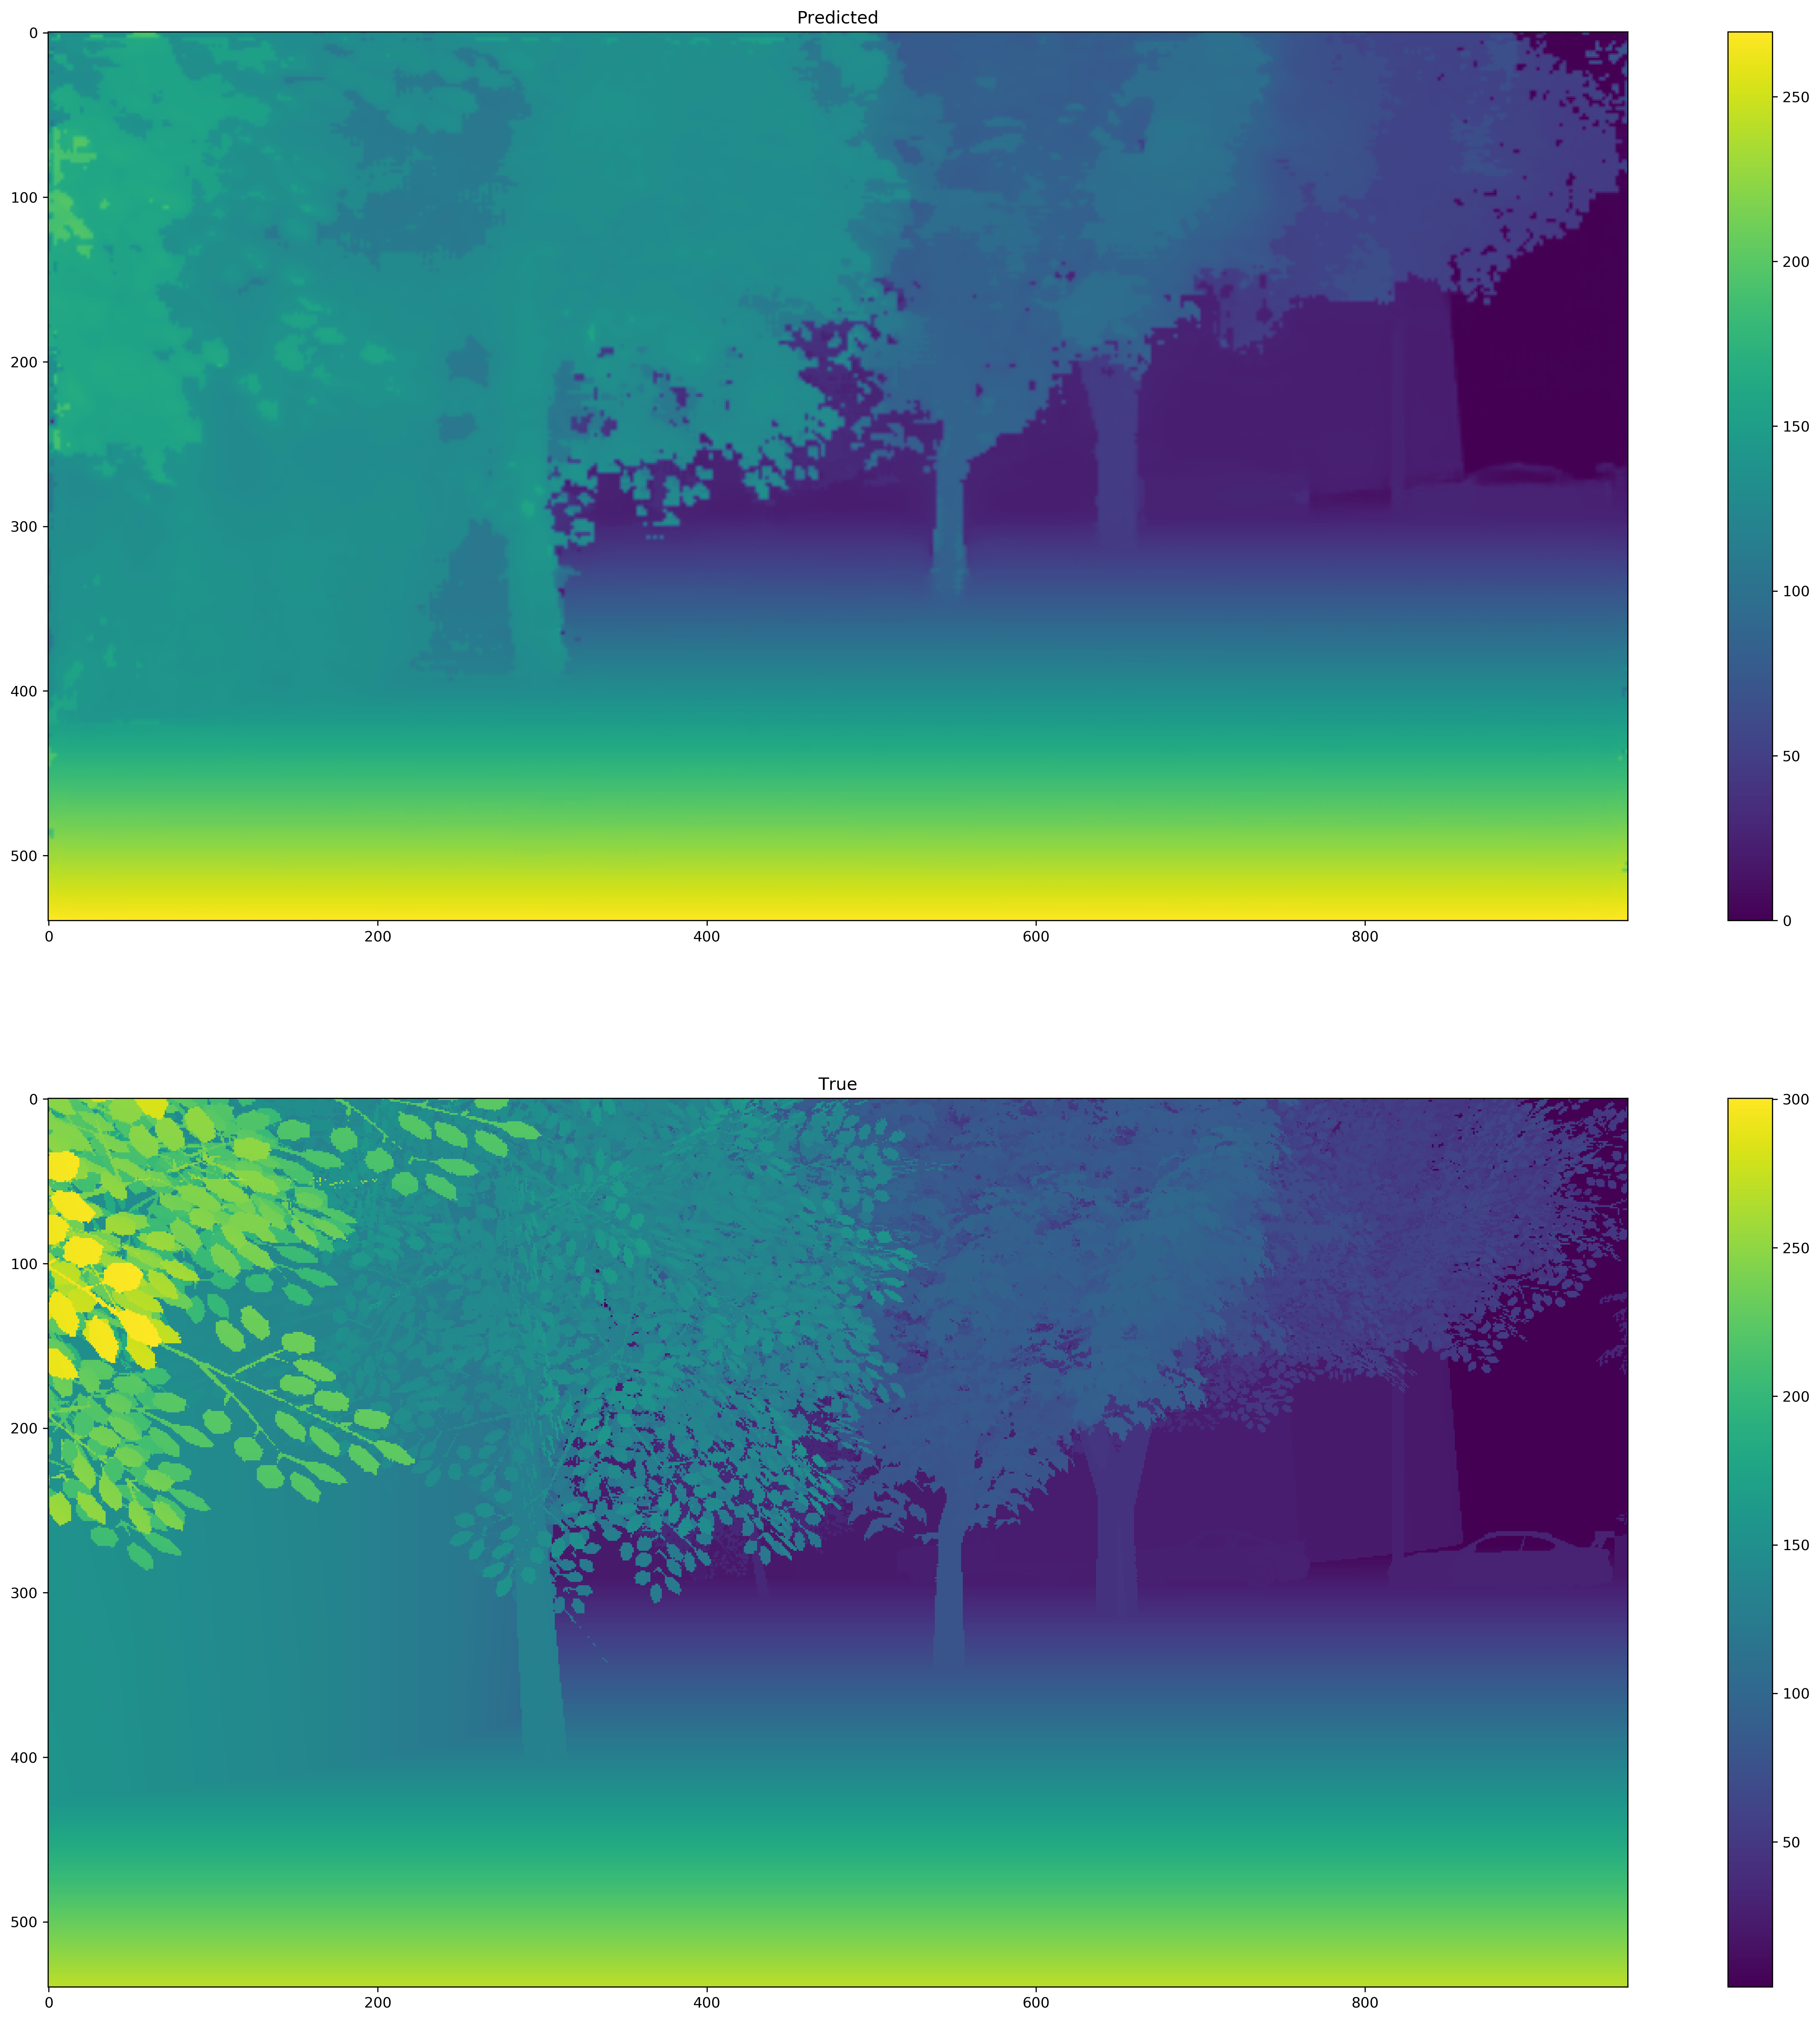

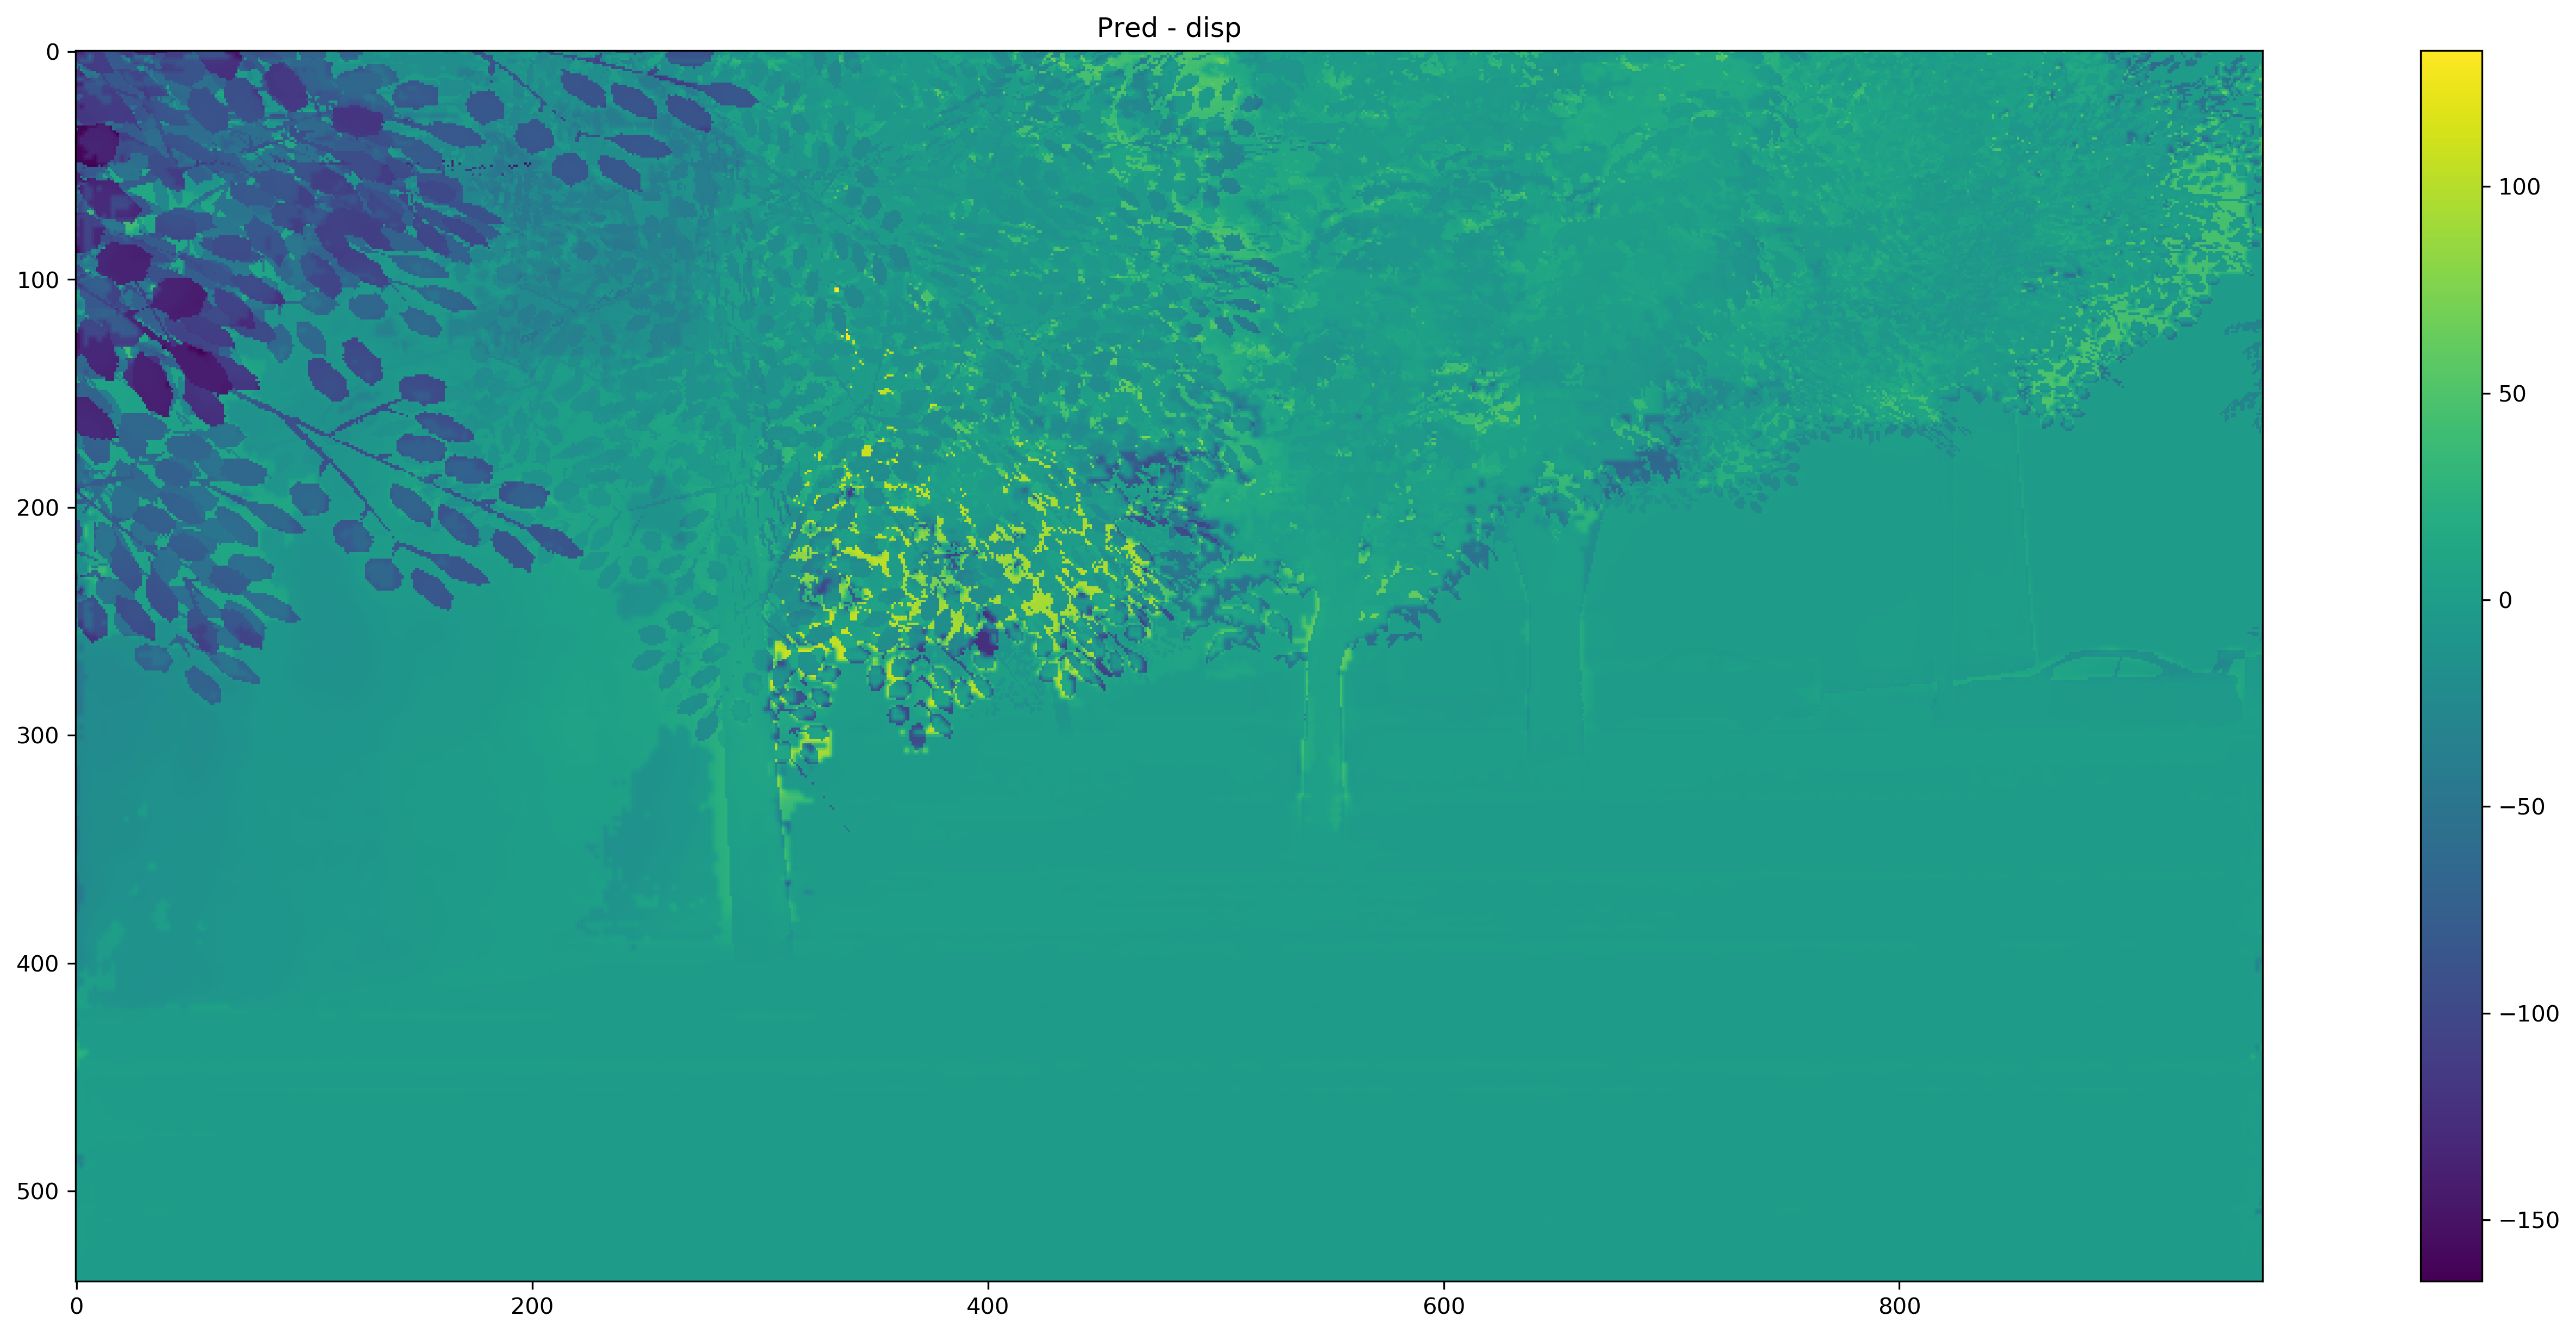

In [26]:
pred_disp = disp0.data.cpu().numpy()[0,0,:,:]
plt.figure(num=None, figsize=(25,25),dpi=300)
plt.subplot(211)
plt.imshow(pred_disp)
plt.title("Predicted")
plt.colorbar()
plt.subplot(212)
plt.imshow(disp_map0)
plt.colorbar()
plt.title("True")

plt.figure(num=None, figsize=(25,10),dpi=300)
plt.imshow(pred_disp-disp_map0)
plt.colorbar()
plt.title("Pred - disp")

In [73]:
# for param in seg_net.parameters():
#     l1(param,torch.zeros_like(param))

In [23]:
np.concatenate((left_img, right_img), 0).shape

(6, 540, 960)

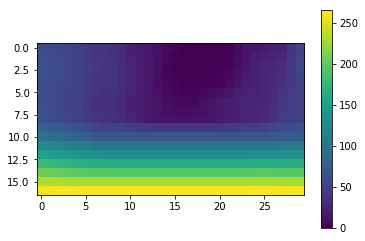

In [22]:
pred_disp = disp6.data.cpu().numpy()[0,0,:,:]
plt.imshow(pred_disp)
plt.colorbar()

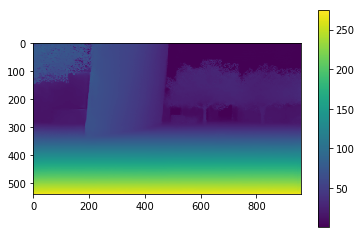

In [28]:
pred_disp = disp0.data.cpu().numpy().reshape((540, 960))
plt.imshow(pred_disp)
plt.colorbar()